In [1]:
import os
import pandas as pd
import numpy as np
import plotnine as p9
import pycmap
import re
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import warnings
from dateutil.parser import parse
from diel_tools import *
from fig_tools import *
from tsd_functions import *
import requests
import io
import matplotlib.dates as mdates
# suppress warnings
warnings.simplefilter('ignore')

ModuleNotFoundError: No module named 'astral'

### Pull in Seaflow data from CMAP
#### If you don't have an API key, please make one on simonscmap: https://simonscmap.com/apikeymanagement

In [15]:
## call CMAP to get seaflow datasets
key =!tail ".cmap_key"    # reading the last line from a file using a system command
api = pycmap.API(token=key[0]) 
# read in seaflow dataset (surface level- 5m- continuous samples across 50 cruises)
seaflow = api.get_dataset('tblSeaFlow_v1_5') # this is the new seaflow dataset versions

In [16]:
# look at what is in the dataset
seaflow.columns

Index(['time', 'lat', 'lon', 'depth', 'cruise', 'abundance_prochloro',
       'abundance_synecho', 'abundance_picoeuk', 'abundance_croco',
       'diam_prochloro', 'diam_synecho', 'diam_picoeuk', 'diam_croco',
       'Qc_prochloro', 'Qc_synecho', 'Qc_picoeuk', 'Qc_croco',
       'biomass_prochloro', 'biomass_synecho', 'biomass_picoeuk',
       'biomass_croco'],
      dtype='object')

### Fitting the data for the model

In [17]:
# melt data from wide to long
seaflow['id'] = seaflow.index
long_sf = pd.wide_to_long(seaflow, stubnames=['abundance', 'diam', 'Qc', 'biomass'],
                sep='_',
                i='id', 
                j='pop',
               suffix='\w+').reset_index().drop(columns=['id']).rename(columns={'diam':'diam_med'})

### Taking a subsample of the cruises: Let's start with the Meso-Scope cruises

In [18]:
# run for mesoscope cruises (lagrangian sampling cruises)
meso_cruises = ['KM1513','KM1709']
meso_samp = long_sf[long_sf['cruise'].isin(meso_cruises)]
# convert time to be in correct format
meso_samp['time'] = pd.DatetimeIndex(meso_samp['time'].apply(lambda x: parse(x))).tz_localize('UTC')

#### Let's merge the data we have from the sfl files to get information on par and temperature from the ship
#### SFL github: https://github.com/seaflow-uw/seaflow-sfl

In [19]:
# no good automated of getting names yet, best to just go through the seaflow log
sfl_names = ['SCOPE_6_740.sfl', 'MESO_SCOPE_751.sfl']
url = "https://raw.githubusercontent.com/seaflow-uw/seaflow-sfl/master/curated"
cruise_list = [meso_samp.loc[meso_samp['cruise']==n] for n in pd.unique(meso_samp['cruise'])]
meso_hourly = []
# pull from sfl files based on names
for name, cruise in zip(sfl_names, cruise_list):
    test = f'{url}/{name}'
    req = requests.get(test).content
    # decode and clean up data
    df = pd.read_csv(io.StringIO(req.decode('utf-8')), sep="\t", lineterminator='\n')
    df = df[df['LAT'].notnull()][['DATE', 'LAT','LON','SALINITY','PAR','OCEAN TEMP']]
    # change column names to match before merge
    df.columns= df.columns.str.lower()
    df.rename(columns={'date':'time', 'ocean temp': 'temp'}, inplace=True)
    # fix time and dtype
    df['time'] = pd.DatetimeIndex(df['time'].apply(lambda x: parse(x))).tz_convert('UTC')
    # merge with each dataframe
    sfl_cruise=cruise.merge(df, on=['time','lat','lon'], how='left')
    # summarize into hourly intervals
    merge_hourly = sfl_cruise.groupby([pd.Grouper(key="time", freq='1H'), 
                                pd.Grouper(key="cruise"), 'pop']).mean().reset_index()
    # pro and syn only
    pops = ['prochloro', 'synecho']
    merge_hourly = merge_hourly.loc[merge_hourly['pop'].isin(pops)]
    meso_hourly.append(merge_hourly)

#### Where did this cruise go? 

In [ ]:
# make a single point for all data points per sample 
cruise_trax = pd.concat(meso_hourly).groupby(['time', 'lat','lon']).first().reset_index()
fig = px.scatter_geo(cruise_trax, lat='lat',lon='lon',color='cruise', opacity=0.1, range_color=[0,40])
fig.update_geos(lataxis_showgrid=True, lonaxis_showgrid=True)
# focus point
lat_foc = 22
lon_foc = -156.5
fig.update_layout(
        geo = dict(
            projection_scale=10, #this is kind of like zoom
            center=dict(lat=lat_foc, lon=lon_foc), # this will center on the point
        )
)

#### What does Pro/Syn diameter look like on these cruises?

In [ ]:
fig = px.scatter(pd.concat(meso_hourly), x='time', y='diam_med', facet_col='cruise', facet_row='pop', color='pop')
pretty_plot(fig, rescale_x=True)

#### We have some missing data that needs to be resolved before running a time series decomposition model
#### Here, the run_TSD function will lineraly interpolate the values before running the data on a rolling hourly basis for 3 day windows
#### In addition, we'll look at the residuals and strengths of each component
This model is a multiplicative function, which can be written as: 
$$Y_t = T_t * S_t * R_t $$
which can also be written as:
$$log(Y_t) = log(T_t) + log(S_t) + log(R_t) $$

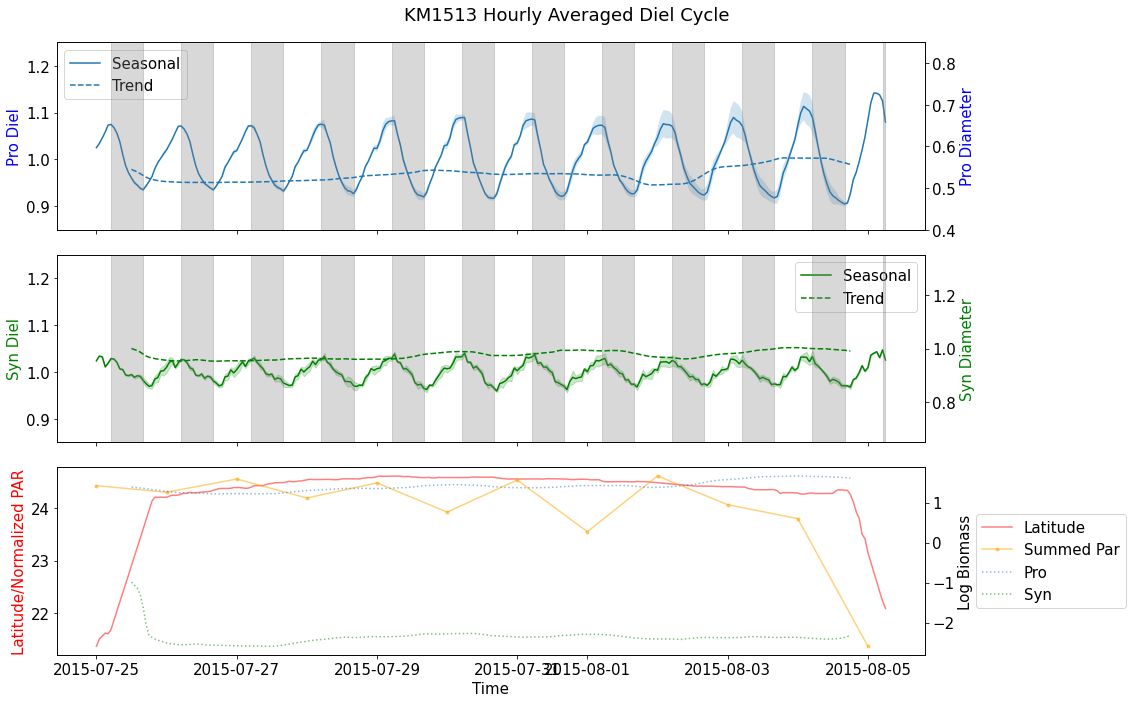

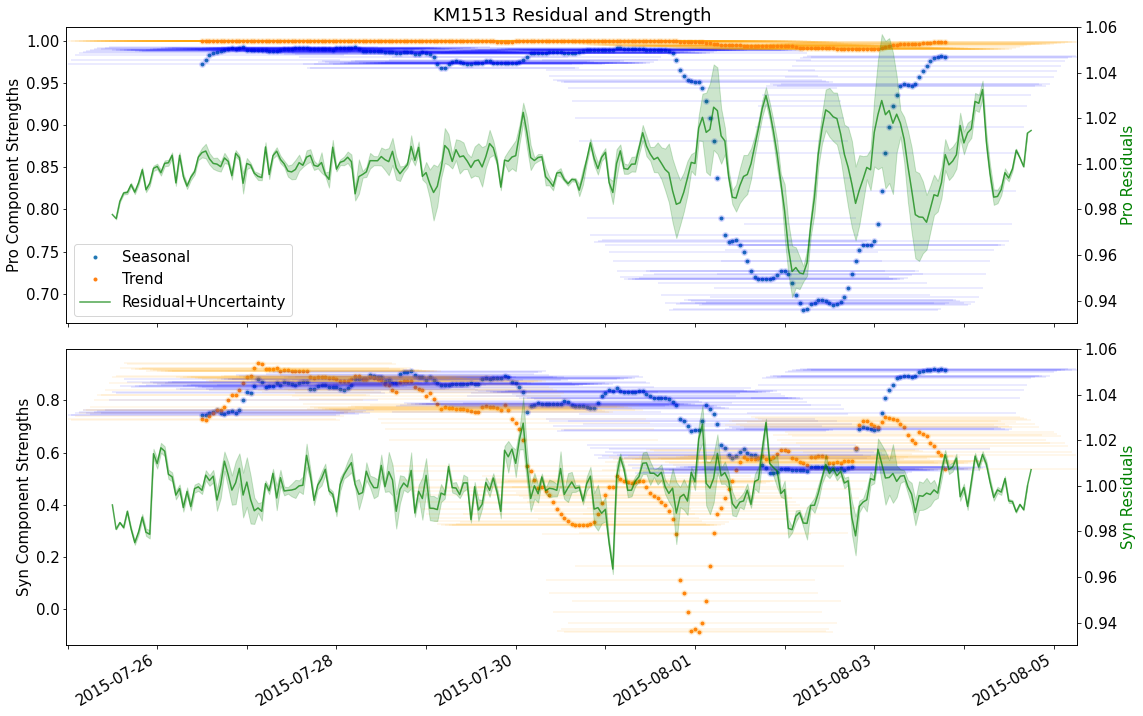

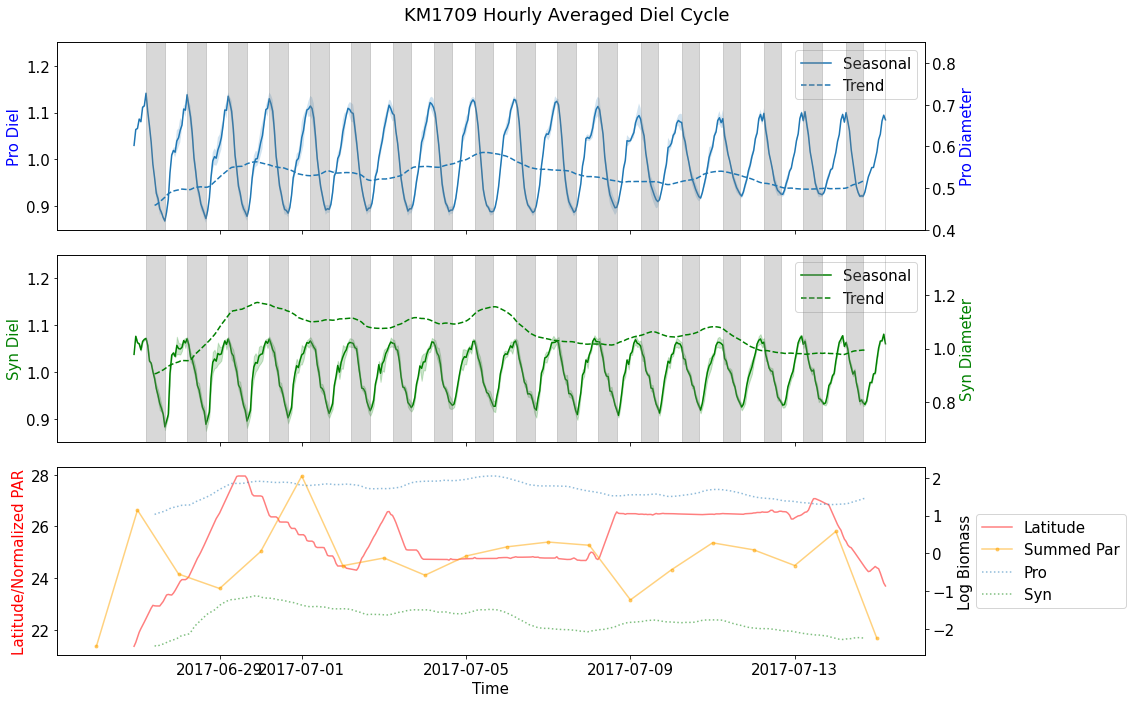

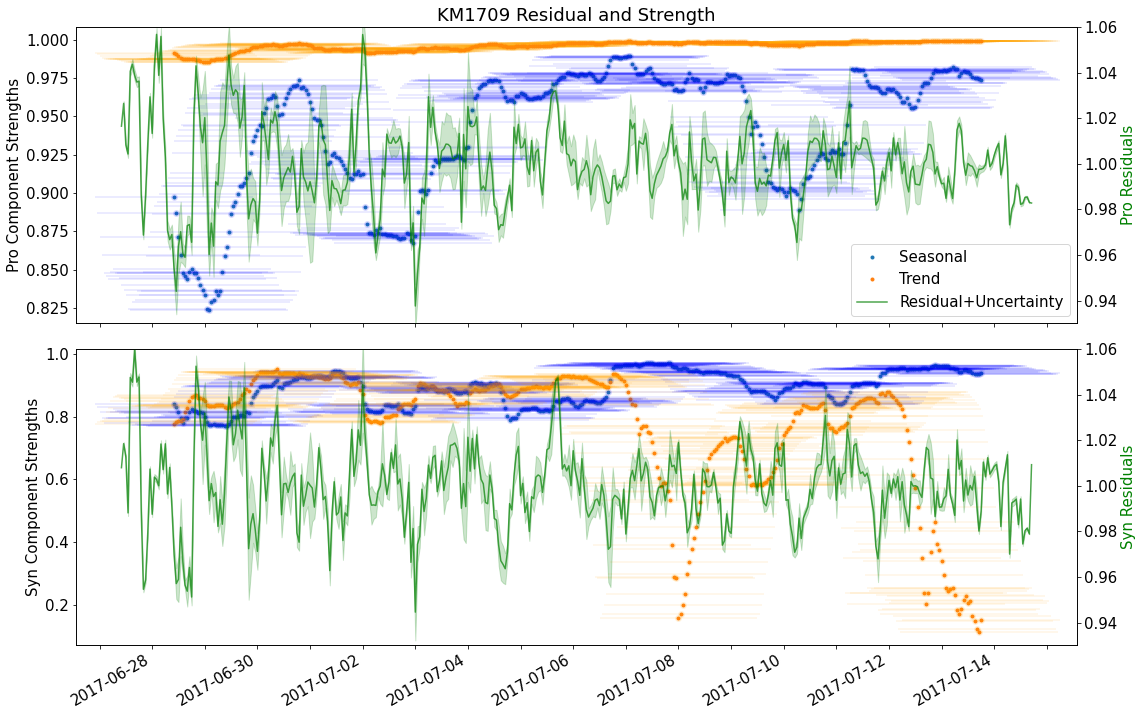

In [20]:
for name, cruise in zip(meso_cruises, meso_hourly):
    seasonal, trend, resid, plot0 = run_TSD(cruise, name, False)
    df, plot1 = component_strength(resid, seasonal, trend, name)    